In [1]:
from mosaic_tracker import ParticleTracker, TrackerParameters, plot_detection_comparison, plot_frame_with_particles, plot_trajectories, plot_trajectory, plot_msd
import matplotlib.pyplot as plt

# MosaicSuiteと同じパラメータ設定
params = TrackerParameters(
    radius=3,              # 粒子半径
    percentile=2,        # 上位0.5%を候補（多くしたい場合は1.0や2.0に）
    cutoff_score=0.1,        # Non-particle discriminationは無効
    max_displacement=8,
    link_range=1,
    min_length=40,
    pixel_size=0.26,
    frame_interval=0.1,
    use_gpu=True          # CuPyがあればTrueにして高速化
)

tracker = ParticleTracker(params)
tracker.load_movie("test.tif")


mosaic_tracker v0.2.0: GPU acceleration available (CuPy)


ParticleTracker(n_frames=100, n_particles=0, n_trajectories=0)

Detected 142 particles


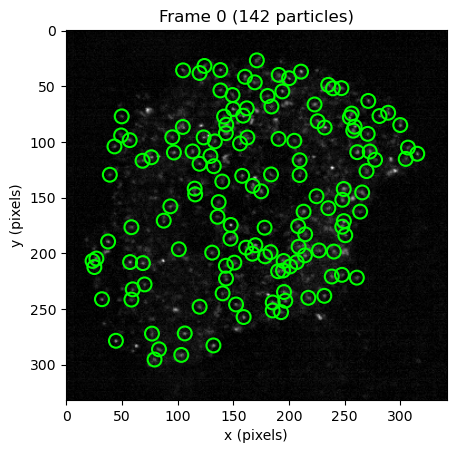

In [2]:
# プレビューでパラメータ調整
filtered, particles = tracker.preview_detection(frame_idx=0)
print(f"Detected {len(particles)} particles")
# 検出結果を可視化（中抜きの丸）
fig, ax = plt.subplots()
plot_frame_with_particles(tracker.movie, [particles], frame_idx=0, ax=ax)
plt.show()

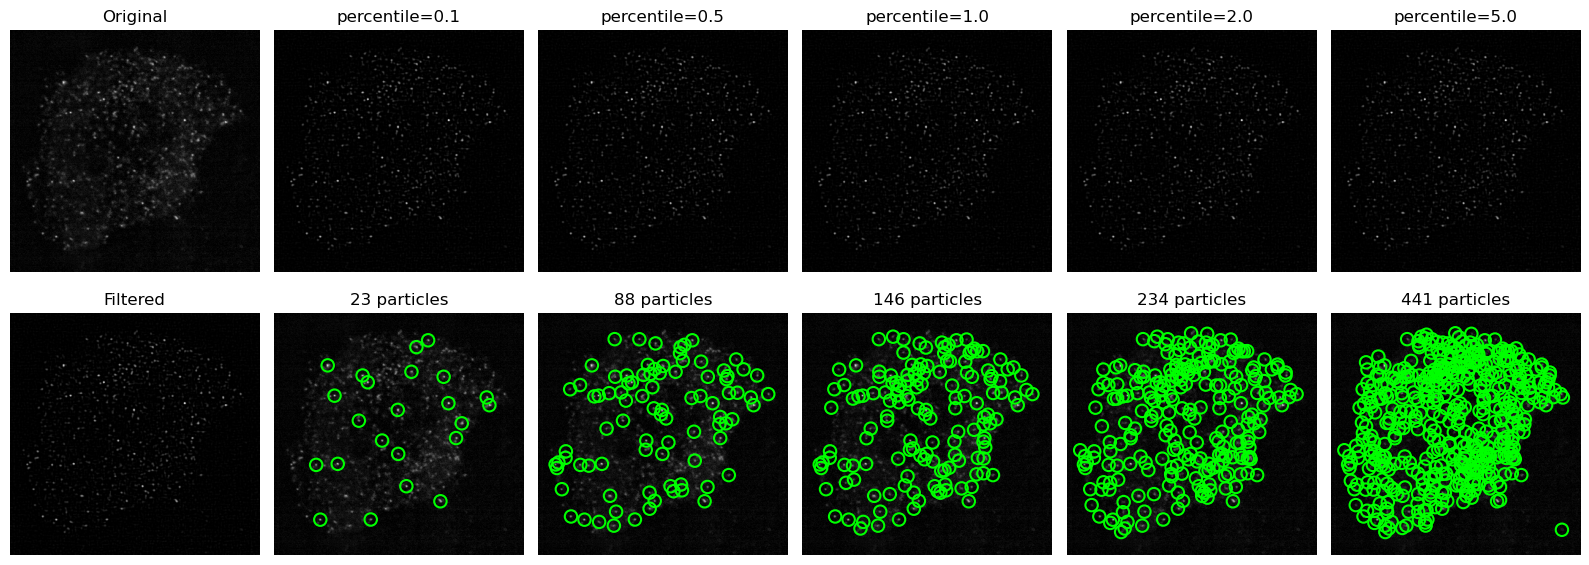

In [3]:
# percentileを変えて比較
from mosaic_tracker import plot_detection_comparison
fig = plot_detection_comparison(tracker.movie[0], radius=2, 
                                percentiles=[0.1, 0.5, 1.0, 2.0, 5.0])
plt.show()

In [4]:
# 本番実行
tracker.detect_particles(verbose=True)
tracker.link_trajectories()
print(tracker.summary())

Using GPU acceleration (CuPy)
Processing frame 1/100
Processing frame 100/100
Total particles detected: 16945 (169.4/frame)
Particle Tracking Summary
Movie: 100 frames, 332x342 pixels
Detected particles: 16945
  Mean per frame: 169.4
Trajectories: 2
  Mean length: 56.0 frames


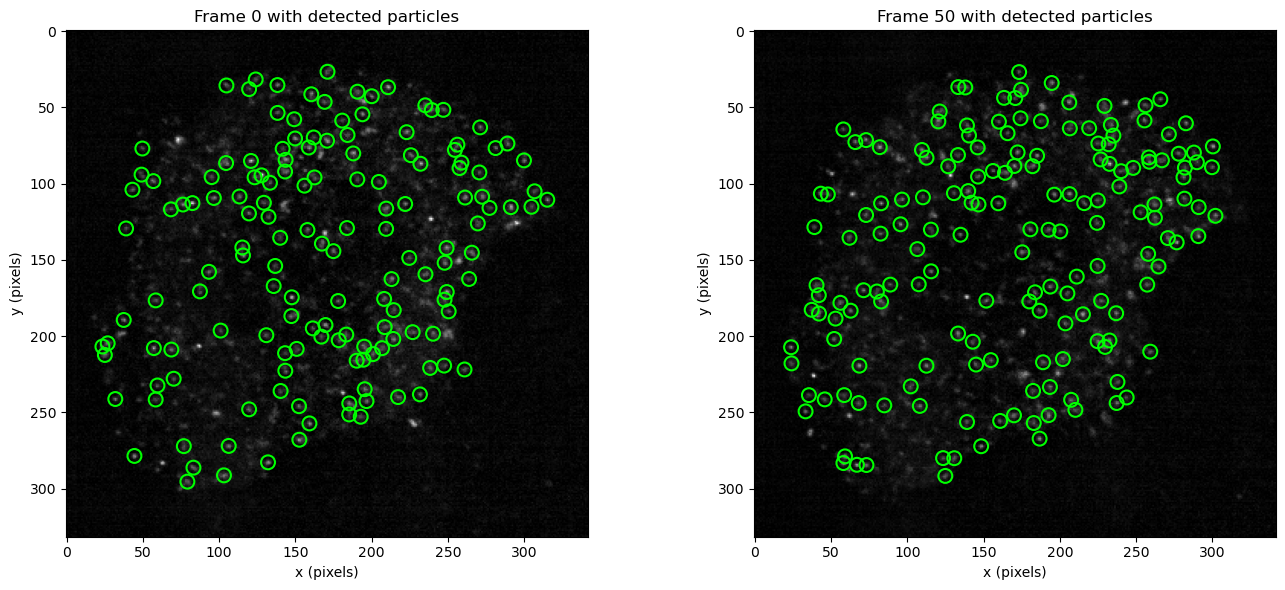

In [6]:
# Visualize detection results
import tifffile
movie = tifffile.imread('test.tif')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_frame_with_particles(movie, tracker.particles, frame_idx=0, ax=axes[0])
axes[0].set_title('Frame 0 with detected particles')
plot_frame_with_particles(movie, tracker.particles, frame_idx=50, ax=axes[1])
axes[1].set_title('Frame 50 with detected particles')
plt.tight_layout()
plt.show()

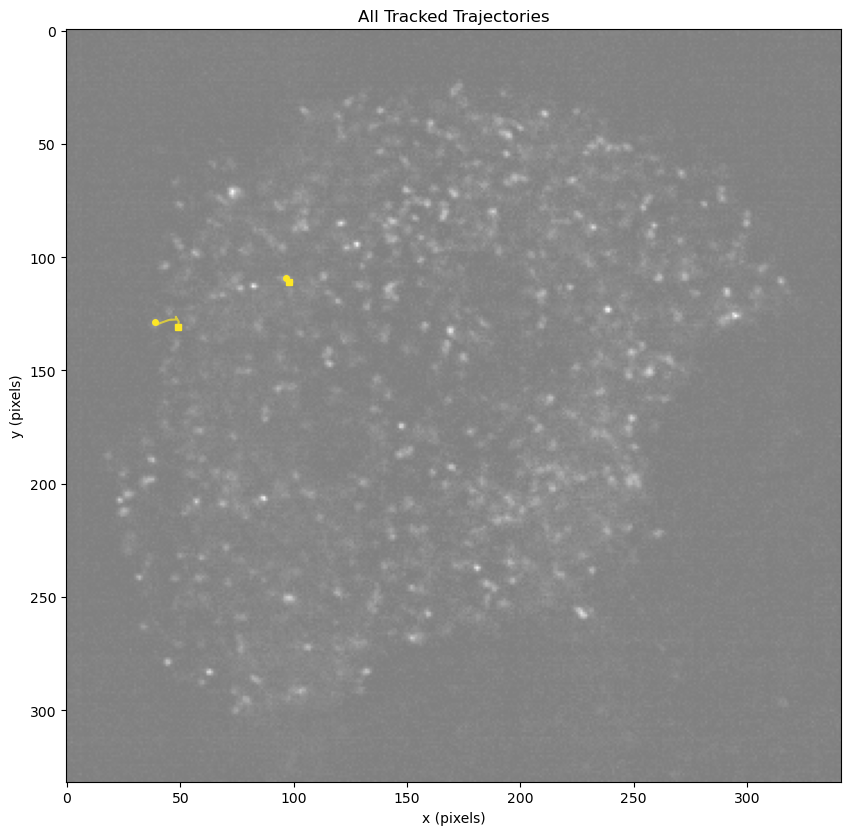

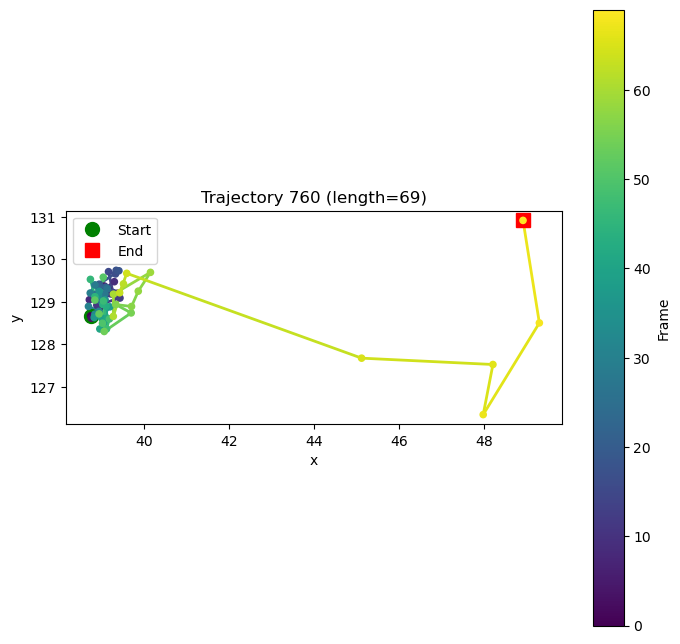

In [7]:
# Visualize all trajectories
fig, ax = plt.subplots(figsize=(10, 10))
plot_trajectories(tracker.trajectories,ax=ax,color_by='id',alpha=0.7,linewidth=1.5,background=movie[0])
plt.title('All Tracked Trajectories')
plt.show()
# Visualize a single trajectory with time coloring
if tracker.trajectories:
    # Get the longest trajectory
    longest_traj = max(tracker.trajectories, key=lambda t: t.length)
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_trajectory(longest_traj, ax=ax, color_by_time=True)
    plt.title(f'Trajectory {longest_traj.id} (length={longest_traj.length})')
    plt.show()

In [ ]:
# Run analysis on all trajectories
results = tracker.analyze()
print(f"Analyzed {len(results)} trajectories")
print(tracker.summary())
# Get summary as DataFrame
df = tracker.get_summary_dataframe()
df.head(10)

In [ ]:
# Plot MSD for a specific trajectory
if tracker.trajectories:
    traj_id = tracker.trajectories[0].id
    msd = tracker.get_msd(traj_id)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_msd(msd, ax=ax)
    plt.title(f'MSD for Trajectory {traj_id}')
    plt.show()
    
    print(f"Diffusion coefficient: {msd.diffusion_coeff:.4f} µm²/s")
    print(f"Alpha (anomalous exponent): {msd.slope:.3f}")
    print(f"Motion type: {msd.motion_type}")